In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import sklearn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [7]:
import skimage.io as io
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter

/Users/jenson/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jenson/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [8]:
trkp_files = []
trkn_files = []
emcal_files = []
hcal_files = []
truth_files = []

In [9]:
directory = "/Users/jenson/Downloads/Gauss_S1.00_NL0.30_B0.50"

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    
    if "trkp" in file_path:
        trkp_files.append(file_path)
    elif "trkn" in file_path:
        trkn_files.append(file_path)
    elif "emcal" in file_path:
        emcal_files.append(file_path)
    elif "hcal" in file_path:
        hcal_files.append(file_path)
    elif "truth" in file_path:
        truth_files.append(file_path)

In [10]:
def key(s):
    matches = re.findall(r'\d+', s)
    return int(matches[-1]) if matches else float('inf')


trkp_files = sorted(trkp_files, key = key)
trkn_files = sorted(trkn_files, key = key)
emcal_files = sorted(emcal_files, key = key)
hcal_files = sorted(hcal_files, key = key)
truth_files = sorted(truth_files, key = key)



short_trkp_files = trkp_files[:2000]
short_trkn_files = trkn_files[:2000]
short_emcal_files = emcal_files[:2000]
short_hcal_files = hcal_files[:2000]
short_truth_files = truth_files[:2000]

In [11]:
trkp_data = np.array(list(map(io.imread, short_trkp_files)))
trkn_data = np.array(list(map(io.imread, short_trkn_files)))
emcal_data = np.array(list(map(io.imread, short_emcal_files)))
hcal_data = np.array(list(map(io.imread, short_hcal_files)))
truth_data = np.array(list(map(io.imread, short_truth_files)))


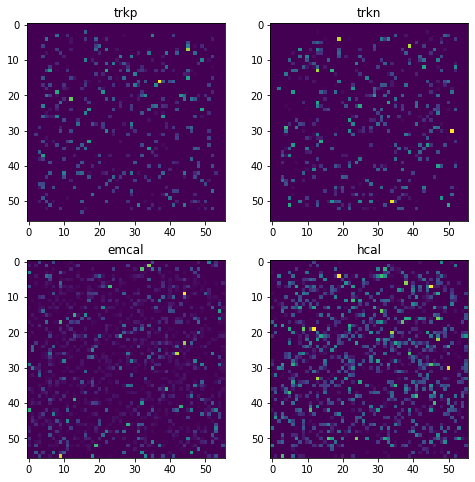

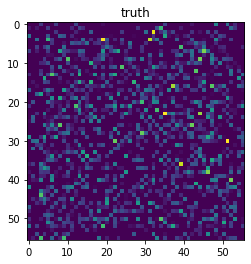

In [12]:
fig = plt.figure(figsize = (8,8))
plt.subplot(2,2,1)
plt.imshow(trkp_data[0])
plt.title("trkp")

plt.subplot(2,2,2)
plt.imshow(trkn_data[0])
plt.title("trkn")

plt.subplot(2,2,3)
plt.imshow(emcal_data[0])
plt.title("emcal")

plt.subplot(2,2,4)
plt.imshow(hcal_data[0])
plt.title("hcal")
plt.show()


plt.imshow(truth_data[0])
plt.title("truth")
plt.show()


In [13]:
X = np.array(list(zip(trkp_data,
        trkn_data,
        emcal_data,
        hcal_data)))

y = truth_data


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)


train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size = 100, shuffle = False)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size = 100, shuffle = False)

# Nested U-net model

In [14]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(VGGBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

In [15]:
class Nested_U_net(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision = False):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.deep_supervision = deep_supervision
        #encoder path (col0)
        self.conv_0_0 = VGGBlock(in_channels, 8, 8)
        self.conv_1_0 = VGGBlock(8, 16, 16)
        self.conv_2_0 = VGGBlock(16, 32, 32)
        self.conv_3_0 = VGGBlock(32, 64, 64)
        
        #col 1
        self.conv_0_1 = VGGBlock(24, 32, 32)
        self.conv_1_1 = VGGBlock(48, 32, 32)
        self.conv_2_1 = VGGBlock(96, 16, 16)
        
        
        #col 2
        self.conv_0_2 = VGGBlock(64 ,16, 16)
        self.conv_1_2 = VGGBlock(48, 8, 8)
        
        #col 3
        self.conv_0_3 = VGGBlock(24, 8, 8)
        
        
        
        #outputs
        self.final_0_1 = nn.Conv2d(32, out_channels, kernel_size=3, stride=1, padding=1)
        self.final_0_2 = nn.Conv2d(16, out_channels, kernel_size=3, stride=1, padding=1)
        self.final_0_3 = nn.Conv2d(8, out_channels, kernel_size=3, stride=1, padding=1)
       
    def forward(self, x):
        x_0_0 = self.conv_0_0(x)
        x_1_0 = self.conv_1_0(self.pool(x_0_0))
        x_0_1 = self.conv_0_1(torch.cat([x_0_0,self.up(x_1_0)], dim = 1))
        
        x_2_0 = self.conv_2_0(self.pool(x_1_0))
        x_1_1 = self.conv_1_1(torch.cat([x_1_0, self.up(x_2_0)], dim = 1))
        x_0_2 = self.conv_0_2(torch.cat([x_0_1, self.up(x_1_1)], dim = 1))
        
        x_3_0 = self.conv_3_0(self.pool(x_2_0))
        x_2_1 = self.conv_2_1(torch.cat([x_2_0, self.up(x_3_0)], dim = 1))
        x_1_2 = self.conv_1_2(torch.cat([x_1_1, self.up(x_2_1)], dim = 1))
        x_0_3 = self.conv_0_3(torch.cat([x_0_2, self.up(x_1_2)], dim = 1))
        
       
        if self.deep_supervision:
            return [self.final_0_1(x_0_1),
                    self.final_0_2(x_0_2),
                    self.final_0_3(x_0_3)]
            
        else:
            
            return [self.final_0_3(x_0_3)]
        

In [17]:
class Output_processor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1, stride=1, padding=0, bias=False)
        
        # Set the weights to average the input images
        with torch.no_grad():
            # Each input channel should contribute equally, so set weights to 1/3
            self.conv.weight.data.fill_(1/3)

    def forward(self, x):
        return self.conv(x)

#  model training

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
network = Nested_U_net(4, 1, deep_supervision = True).to(device)
loss_func = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(network.parameters(), lr = 0.01)

cpu


In [2]:
from tqdm import tqdm

In [3]:
output_loss_1 = []
output_loss_2 = []
output_loss_3 = []


In [4]:
#如果效果不好把 deep_supervision 设为 False!!
for epoch in range(80):
    for count, (data, mask) in enumerate(tqdm(train_loader)):
        mask = mask.resize(data.size(0), 1, 56, 56)   
        optimizer.zero_grad()
        out = network(data)
        if getattr(network, "deep_supervision"):
            tot_loss = sum([loss_func(i, mask) for i in out])
            loss1 = loss_func(out[0], mask)
            loss2 = loss_func(out[1], mask)
            loss3 = loss_func(out[2], mask)
        else:
            tot_loss = loss_func(out[-1], mask)
            loss1, loss2, loss3 = None, None, None
            
        if (loss1, loss2, loss3) != (None, None, None):
            output_loss_1.append(loss1.item())
            output_loss_2.append(loss2.item())
            output_loss_3.append(loss3.item())
            
        tot_loss.backward()
        optimizer.step()
        
    print(f"epochs: {epoch}, overall loss: {tot_loss.item()}, losses:{loss1.item(), loss2.item(), loss3.item()} lr:{optimizer.param_groups[0]['lr']}")
        

NameError: name 'train_loader' is not defined

# processor training

In [337]:
processor = Output_processor().to(device)
criteria = nn.MSELoss().to(device)
optim = torch.optim.Adam(processor.parameters(), lr = 0.01)

In [340]:
for epoch in range(20):
    for count, (data, mask) in enumerate(tqdm(train_loader)):
        mask = mask.resize(data.size(0), 1, 56, 56)   
        optim.zero_grad()
        network_out = torch.stack(network(data), dim = 1)
       
        out = processor(network_out.resize(network_out.size(0), 3, 56, 56))
        
        loss = criteria(out, mask) 
        loss.backward()
        optim.step()
        
    print(f"epochs: {epoch},loss: {loss.item()}  lr:{optim.param_groups[0]['lr']}")
        

100%|███████████████████████████████████████████| 14/14 [01:04<00:00,  4.62s/it]


epochs: 0,loss: 0.05832114815711975  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:59<00:00,  4.25s/it]


epochs: 1,loss: 0.058186016976833344  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:57<00:00,  4.08s/it]


epochs: 2,loss: 0.0580810010433197  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:55<00:00,  3.93s/it]


epochs: 3,loss: 0.05809438228607178  lr:0.01


  7%|███▏                                        | 1/14 [00:13<02:50, 13.11s/it]


KeyboardInterrupt: 

# eval

In [ ]:
best_output = torch.argmin(torch.tensor([output_loss_1[-1], output_loss_2[-1], output_loss_3[-1]]))


In [ ]:
from torcheval.metrics.functional import r2_score

In [ ]:
Rms = lambda x : np.sqrt(np.mean(x**2))

In [341]:

#with mean output
with torch.no_grad():
    tot_rms = 0
    count = 0
    for c, (data, target) in enumerate(test_loader):
        
        if c<5:
            for i in range(data.size(0)):

                inputs = data[i].resize(1, 4, 56, 56)
                out = torch.mean(torch.stack(network(inputs)), dim = 0).reshape(56, 56).flatten().numpy()

                truth = target[i].reshape(56,56).flatten().numpy()
                error = out - truth
                tot_rms += Rms(error)
                count += 1
    print(f"average rms for first 500 images in test loader: {tot_rms/count}")
        

average rms for first 500 images in test loader: 0.25377476853132247


In [334]:
#with last output

with torch.no_grad():
    tot_rms = 0
    count = 0
    for c, (data, target) in enumerate(test_loader):
    
        if c<5:
            for i in range(data.size(0)):

                inputs = data[i].resize(1, 4, 56, 56)
                out = network(inputs)[-1].reshape(56, 56).flatten().numpy()

                truth = target[i].reshape(56,56).flatten().numpy()
                error = out - truth
                tot_rms += Rms(error)
                count += 1
    print(f"average rms for first 500 images in test loader: {tot_rms/count}")

average rms for first 500 images in test loader: 0.2680172203779221


In [335]:
#with selected output
with torch.no_grad():
    tot_rms = 0
    count = 0
    for c, (data, target) in enumerate(test_loader):
        
        if c<5:
            for i in range(data.size(0)):

                inputs = data[i].resize(1, 4, 56, 56)
                out = network(inputs)[best_output].reshape(56, 56).flatten().numpy()

                truth = target[i].reshape(56,56).flatten().numpy()
                error = out - truth
                tot_rms += Rms(error)
                count += 1
    print(f"average rms for first 500 images in test loader: {tot_rms/count}")

average rms for first 500 images in test loader: 0.2668129825294018


In [316]:
#with combined output
with torch.no_grad():
    tot_rms = 0
    count = 0
    for c, (data, target) in enumerate(test_loader):
        
        if c<5:
            for i in range(data.size(0)):

                inputs = data[i].resize(1, 4, 56, 56)
                
                out = torch.stack(network(inputs)).resize(3, 56, 56)
                out = processor(out).reshape(56, 56).flatten().numpy()
                
                truth = target[i].reshape(56,56).flatten().numpy()
                error = out - truth
                tot_rms += Rms(error)
                count += 1
    print(f"average rms for first 500 images in test loader: {tot_rms/count}")

average rms for first 500 images in test loader: 0.24879703640937806


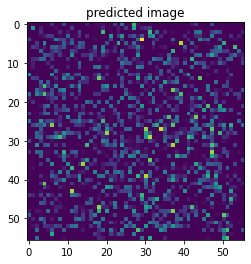

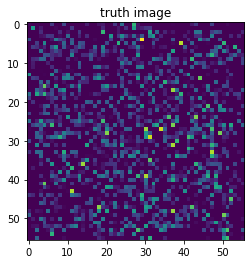

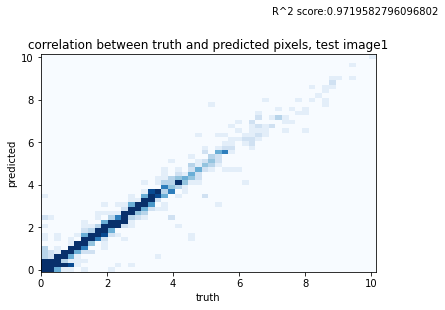

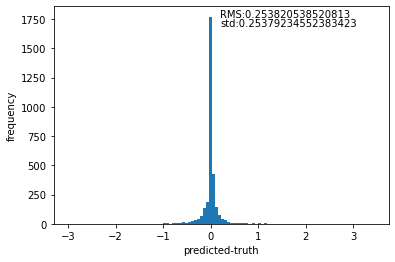

In [317]:
network.eval()
with torch.no_grad():
    for count, (data, target) in enumerate(test_loader):
        inputs = data[count].resize(1, 4, 56, 56)
        
        output = processor(torch.stack(network(inputs)).resize(1, 3, 56, 56)).reshape(56, 56)
        target = target[count]
        break
        
    plt.imshow(output)
    plt.title('predicted image')
    plt.show()
    plt.imshow(target)
    plt.title('truth image')
    plt.show()



plt.hist2d(target.numpy().flatten(),output.numpy().flatten(), bins = (50,50), vmax = 10, cmap = "Blues")
plt.xlabel("truth")
plt.ylabel("predicted")
plt.text(7, 12,f"R^2 score:{r2_score(output, target)}")
plt.title(f"correlation between truth and predicted pixels, test image{1}")
plt.show()



error = output.numpy().flatten() - target.numpy().flatten()
h, xedges, yedges = plt.hist(error, bins = 100)



plt.text(0.2,max(h),f"RMS:{Rms(error)}")
plt.text(0.2,max(h)-80,f"std:{np.std(error)}")
plt.xlabel("predicted-truth")
plt.ylabel("frequency")
plt.show()

In [17]:
writer = SummaryWriter('runs/nested_U-net')


dummy_input = torch.randn(1, 4, 56, 56)

model = Nested_U_net(4, 1)

writer.add_graph(model, dummy_input)



writer.close()

In [ ]:
!tensorboard --logdir=runs

/Users/jenson/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jenson/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6006/ (Press CTRL+C to quit)
